CODE BLOCK: 1

In [1]:
from google.colab import files
files.upload()

Saving model.py to model.py
Saving utils.py to utils.py


{'model.py': b"'''\nThis defines the model architecture\n    - 2 Conv2d\n    - MP\n    - 2 Conv2d\n    - MP\n    - 2 linear layers\n'''\n\n\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass Net(nn.Module):\n    #This defines the structure of the NN.\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)\n        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)\n        self.fc1 = nn.Linear(4096, 50)\n        self.fc2 = nn.Linear(50, 10)\n\n    def forward(self, x):\n        x = F.relu(self.conv1(x),2)\n        x = F.relu(F.max_pool2d(self.conv2(x), 2))\n        x = F.relu(self.conv3(x),2)\n        x = F.relu(F.max_pool2d(self.conv4(x), 2))\n        x = x.view(-1, 4096)\n        x = F.relu(self.fc1(x))\n        x = self.fc2(x)\n        return F.log_softmax(x, dim=1)\n",
 'utils.py': b'\n\'\'\'\nUtils for

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from model import Net
from utils import *

CODE BLOCK: 2

In [3]:
# CUDA?
#cuda = if torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA Available?", device)

CUDA Available? cuda


CODE BLOCK: 3

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 160795906.76it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25845038.15it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73014056.13it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7175340.40it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw


CODE BLOCK: 5

In [5]:
batch_size = 512 # 512 but why ?

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

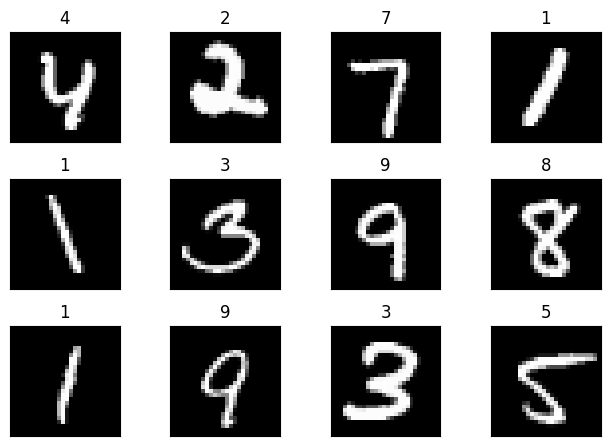

In [6]:
plot_train_samples(train_loader)

CODE BLOCK: 7

CODE BLOCK: 8

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [8]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [9]:
model = Net().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.2939 Batch_id=19 Accuracy=11.35: 100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


Test set: Average loss: 2.2844, Accuracy: 6860/60000 (11.43%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=2.2108 Batch_id=19 Accuracy=20.72: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Test set: Average loss: 2.1796, Accuracy: 25324/60000 (42.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=1.7620 Batch_id=19 Accuracy=54.23: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Test set: Average loss: 5.9872, Accuracy: 20891/60000 (34.82%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=2.2932 Batch_id=19 Accuracy=19.50: 100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Test set: Average loss: 2.2922, Accuracy: 6742/60000 (11.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=2.2628 Batch_id=19 Accuracy=11.35: 100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


Test set: Average loss: 2.2581, Accuracy: 10036/60000 (16.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=2.1609 Batch_id=19 Accuracy=24.83: 100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


Test set: Average loss: 2.1143, Accuracy: 29066/60000 (48.44%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.2946 Batch_id=19 Accuracy=48.27: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


Test set: Average loss: 1.2568, Accuracy: 36737/60000 (61.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=1.3182 Batch_id=19 Accuracy=70.10: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Test set: Average loss: 1.3414, Accuracy: 36773/60000 (61.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.5196 Batch_id=19 Accuracy=71.70: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


Test set: Average loss: 0.7301, Accuracy: 48535/60000 (80.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.3325 Batch_id=19 Accuracy=89.63: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


Test set: Average loss: 0.4493, Accuracy: 52535/60000 (87.56%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1654 Batch_id=19 Accuracy=93.11: 100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


Test set: Average loss: 0.3904, Accuracy: 53595/60000 (89.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.1028 Batch_id=19 Accuracy=94.61: 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


Test set: Average loss: 0.3449, Accuracy: 54268/60000 (90.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1683 Batch_id=19 Accuracy=95.32: 100%|██████████| 20/20 [00:03<00:00,  6.25it/s]


Test set: Average loss: 0.3069, Accuracy: 54968/60000 (91.61%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1082 Batch_id=19 Accuracy=96.04: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Test set: Average loss: 0.3072, Accuracy: 54978/60000 (91.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0872 Batch_id=19 Accuracy=96.46: 100%|██████████| 20/20 [00:02<00:00,  7.05it/s]


Test set: Average loss: 0.2903, Accuracy: 55242/60000 (92.07%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0856 Batch_id=19 Accuracy=96.83: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Test set: Average loss: 0.2721, Accuracy: 55616/60000 (92.69%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.1035 Batch_id=19 Accuracy=97.03: 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


Test set: Average loss: 0.2780, Accuracy: 55511/60000 (92.52%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0974 Batch_id=19 Accuracy=97.11: 100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


Test set: Average loss: 0.2718, Accuracy: 55613/60000 (92.69%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.1082 Batch_id=19 Accuracy=97.15: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


Test set: Average loss: 0.2745, Accuracy: 55619/60000 (92.70%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0694 Batch_id=19 Accuracy=97.18: 100%|██████████| 20/20 [00:02<00:00,  7.47it/s]


Test set: Average loss: 0.2673, Accuracy: 55690/60000 (92.82%)

Adjusting learning rate of group 0 to 1.0000e-03.


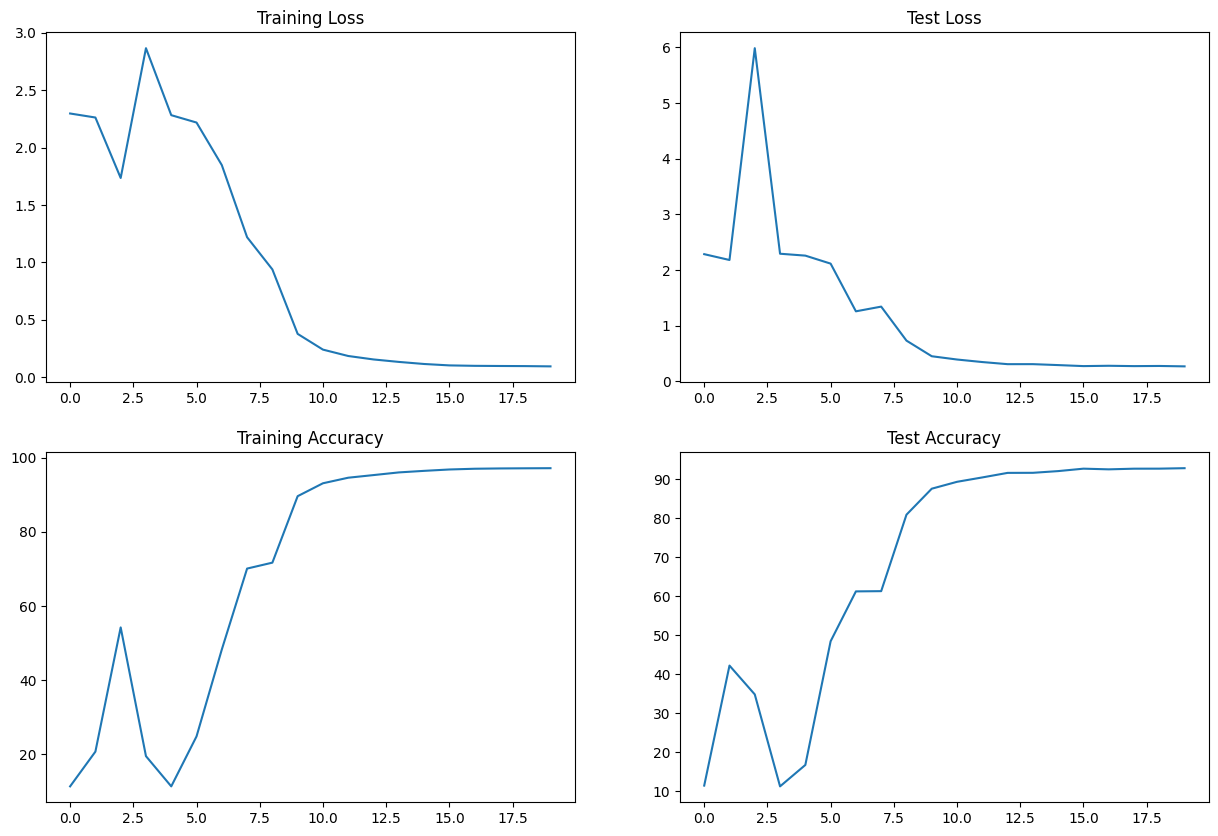

In [11]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
